In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import pandas as pd
import random

In [82]:
torch.manual_seed(15)
random.seed(15)

In [83]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [84]:
augm = 0    # угол наклона изображений
noise_rate = 0  # зашумленность меток
dropout_rate = 0    # коэффициент Dropout слоев
L2 = 0.01  # коэффициент L2 регуляризации
label_smoothing_rate = 0.1    # коэффициент label 

model_name = 'CNN'
if augm > 0: model_name+= f'_augm{augm}'
if noise_rate > 0: model_name += f'_{int(noise_rate*100)}%'
if dropout_rate > 0: model_name += f'_Dropout({dropout_rate})'
if L2 > 0: model_name += f'_L2({L2})'
if label_smoothing_rate > 0: model_name += f'_label_smoothing({label_smoothing_rate})'

path = f'models/{model_name}'
path

'models/CNN_L2(0.01)_label_smoothing(0.1)'

In [3]:
if 'models' not in os.listdir('./'):
        os.mkdir('models')

In [85]:
if model_name in os.listdir('./models'):
        input()

In [86]:
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomRotation(augm),
     transforms.RandomHorizontalFlip(),
     transforms.RandomResizedCrop(size=(28, 28)),
     transforms.Normalize((0.5,), (0.5,))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
    

batch_size = 128

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',          
    train=True,            
    download=True,          
    transform=train_transform     
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,            
    download=True,
    transform=test_transform
)
classes = train_dataset.classes

In [87]:
def labels_noise(dataset, noise_rate: float = 0.0) -> list:
    '''
    Проходимся по датасету и меняем лейблы
    '''
    new_dataset = []
    for i in range(len(dataset)):
        if i in range(int(len(dataset)*noise_rate)):
            new_dataset.append([dataset[i][0], random.choice([x for x in range(10) if x != dataset[i][1]])])
            continue
        new_dataset.append([dataset[i][0], dataset[i][1]])

    return new_dataset

In [88]:
train_dataset = labels_noise(train_dataset, noise_rate)

In [89]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True   
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False  
)


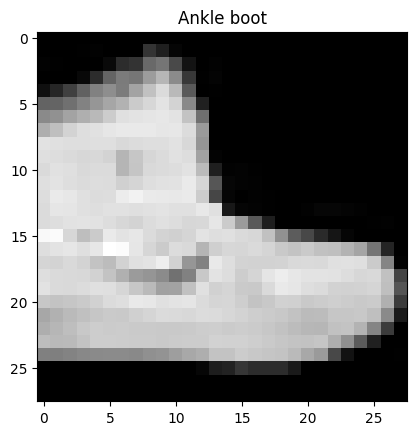

In [90]:
image, label = train_dataset[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(classes[label])
plt.show()

In [91]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*7*7, 512),
            nn.ReLU() if dropout_rate > 0 else nn.Identity(),
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(512, 128),
            nn.ReLU() if dropout_rate > 0 else nn.Identity(),
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.classifier(x)

        return x


In [92]:
net = Net()
net.to(device)


loaded = 0

In [93]:
os.listdir('./models')

['CNN',
 'CNN_10%',
 'CNN_10%_Dropout(0.3)',
 'CNN_10%_Dropout(0.3)_L2(0.0001)',
 'CNN_10%_Dropout(0.3)_L2(0.0001)_label_smoothing(0.1)',
 'CNN_10%_Dropout(0.3)_L2(0.001)',
 'CNN_10%_Dropout(0.3)_L2(0.001)_label_smoothing(0.1)',
 'CNN_10%_Dropout(0.3)_L2(0.01)',
 'CNN_10%_Dropout(0.3)_L2(0.01)_label_smoothing(0.1)',
 'CNN_10%_Dropout(0.3)_label_smoothing(0.1)',
 'CNN_10%_Dropout(0.4)',
 'CNN_10%_Dropout(0.4)_L2(0.0001)',
 'CNN_10%_Dropout(0.4)_L2(0.001)',
 'CNN_10%_Dropout(0.4)_L2(0.01)',
 'CNN_10%_Dropout(0.4)_L2(0.01)_label_smoothing(0.1)',
 'CNN_10%_Dropout(0.4)_label_smoothing(0.1)',
 'CNN_10%_Dropout(0.5)',
 'CNN_10%_Dropout(0.5)_label_smoothing(0.1)',
 'CNN_10%_L2(0.0001)',
 'CNN_10%_L2(0.001)',
 'CNN_10%_L2(0.001)_label_smoothing(0.1)',
 'CNN_10%_L2(0.01)',
 'CNN_10%_L2(0.01)_label_smoothing(0.1)',
 'CNN_10%_label_smoothing(0.1)',
 'CNN_20%',
 'CNN_20%_Dropout(0.3)',
 'CNN_20%_Dropout(0.3)_L2(0.0001)',
 'CNN_20%_Dropout(0.3)_L2(0.0001)_label_smoothing(0.1)',
 'CNN_20%_Dropout(0.

In [94]:
# Загрузка модели
# net = torch.load(f'{path}/{model_name}.pth', weights_only=False)
# loaded = 1
# net.eval()

In [95]:
print(f'Количество параметров - {sum(p.numel() for p in net.parameters())}')

Количество параметров - 3371850


In [96]:
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing_rate)

learning_rate = 0.001
optimizer = optim.SGD(net.parameters(), lr=learning_rate, weight_decay=L2)

In [97]:
if not loaded:
    loss_list = []
    accuracy_list = []
    iters = 0

    epochs = 100

    for epoch in range(epochs):
        total_epoch_loss = 0
        correct = 0
        total = 0
        for data in train_loader:
            iters += 1
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_epoch_loss = total_epoch_loss + loss.item()
            
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total


        avg_loss = total_epoch_loss/len(train_loader)
        loss_list.append(avg_loss)
        accuracy_list.append(accuracy)

        print(f'Epoch: {epoch + 1} , Loss: {avg_loss:.2f} , Accuracy {accuracy:.2f}%')

Epoch: 1 , Loss: 2.03 , Accuracy 35.00%
Epoch: 2 , Loss: 1.74 , Accuracy 47.57%
Epoch: 3 , Loss: 1.62 , Accuracy 51.28%
Epoch: 4 , Loss: 1.55 , Accuracy 53.65%
Epoch: 5 , Loss: 1.51 , Accuracy 55.47%
Epoch: 6 , Loss: 1.48 , Accuracy 56.77%
Epoch: 7 , Loss: 1.45 , Accuracy 57.85%
Epoch: 8 , Loss: 1.43 , Accuracy 58.83%
Epoch: 9 , Loss: 1.41 , Accuracy 59.75%
Epoch: 10 , Loss: 1.39 , Accuracy 60.42%
Epoch: 11 , Loss: 1.38 , Accuracy 61.30%
Epoch: 12 , Loss: 1.36 , Accuracy 61.85%
Epoch: 13 , Loss: 1.35 , Accuracy 62.38%
Epoch: 14 , Loss: 1.34 , Accuracy 63.02%
Epoch: 15 , Loss: 1.33 , Accuracy 63.65%
Epoch: 16 , Loss: 1.32 , Accuracy 64.08%
Epoch: 17 , Loss: 1.31 , Accuracy 64.57%
Epoch: 18 , Loss: 1.30 , Accuracy 65.08%
Epoch: 19 , Loss: 1.29 , Accuracy 65.49%
Epoch: 20 , Loss: 1.28 , Accuracy 65.84%
Epoch: 21 , Loss: 1.27 , Accuracy 66.10%
Epoch: 22 , Loss: 1.26 , Accuracy 66.56%
Epoch: 23 , Loss: 1.26 , Accuracy 66.83%
Epoch: 24 , Loss: 1.25 , Accuracy 67.04%
Epoch: 25 , Loss: 1.24 , 

In [98]:
iters

46900

In [99]:
os.listdir('./models')

['CNN',
 'CNN_10%',
 'CNN_10%_Dropout(0.3)',
 'CNN_10%_Dropout(0.3)_L2(0.0001)',
 'CNN_10%_Dropout(0.3)_L2(0.0001)_label_smoothing(0.1)',
 'CNN_10%_Dropout(0.3)_L2(0.001)',
 'CNN_10%_Dropout(0.3)_L2(0.001)_label_smoothing(0.1)',
 'CNN_10%_Dropout(0.3)_L2(0.01)',
 'CNN_10%_Dropout(0.3)_L2(0.01)_label_smoothing(0.1)',
 'CNN_10%_Dropout(0.3)_label_smoothing(0.1)',
 'CNN_10%_Dropout(0.4)',
 'CNN_10%_Dropout(0.4)_L2(0.0001)',
 'CNN_10%_Dropout(0.4)_L2(0.001)',
 'CNN_10%_Dropout(0.4)_L2(0.01)',
 'CNN_10%_Dropout(0.4)_L2(0.01)_label_smoothing(0.1)',
 'CNN_10%_Dropout(0.4)_label_smoothing(0.1)',
 'CNN_10%_Dropout(0.5)',
 'CNN_10%_Dropout(0.5)_label_smoothing(0.1)',
 'CNN_10%_L2(0.0001)',
 'CNN_10%_L2(0.001)',
 'CNN_10%_L2(0.001)_label_smoothing(0.1)',
 'CNN_10%_L2(0.01)',
 'CNN_10%_L2(0.01)_label_smoothing(0.1)',
 'CNN_10%_label_smoothing(0.1)',
 'CNN_20%',
 'CNN_20%_Dropout(0.3)',
 'CNN_20%_Dropout(0.3)_L2(0.0001)',
 'CNN_20%_Dropout(0.3)_L2(0.0001)_label_smoothing(0.1)',
 'CNN_20%_Dropout(0.

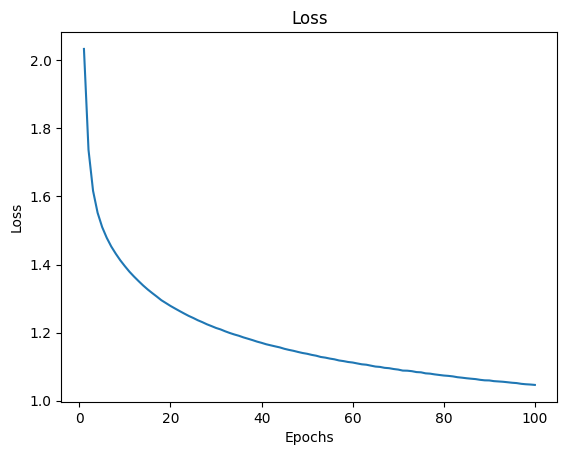

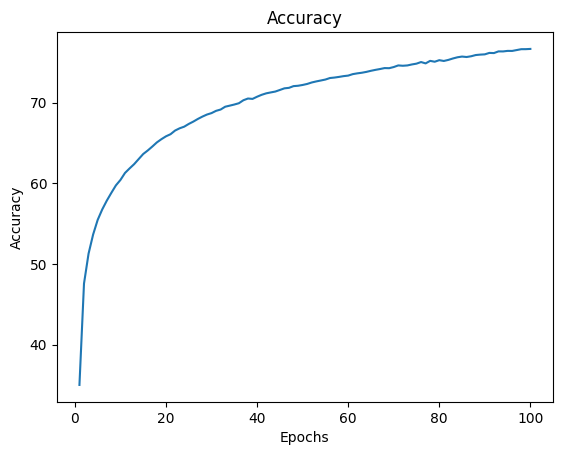

In [100]:
if not loaded:
    if model_name not in os.listdir('./models'):
        os.mkdir(path)

    df = pd.DataFrame({'accuracy': accuracy_list,
                   'loss': loss_list})
    df.to_csv(f'{path}/metrics.csv', index=False)  

    with open(f'{path}/eval.txt', 'w') as f:
        f.write(str(net.eval()))

    iteration_list = list(range(1, epochs+1))
    plt.plot(iteration_list, loss_list)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.savefig(f'{path}/loss_fig.png')
    plt.show()

    plt.plot(iteration_list, accuracy_list)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.savefig(f'{path}/accuracy_fig.png')
    plt.show()

    net.eval() # Начинаем оценивать модель

In [101]:
correct = 0
total = 0
test_epoch_loss = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)
        loss = criterion(outputs, labels)
    

        _, predicted = torch.max(outputs, 1)
        test_epoch_loss += loss.item()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the 10000 test images: {100 * correct / total:.2f} %')
print(f'Loss on the 10000 test images: {test_epoch_loss/len(test_loader)}')

if not loaded:
    df = pd.DataFrame({'accuracy': [100 * correct / total],
                   'loss': [test_epoch_loss/len(test_loader)]})
    df.to_csv(f'{path}/test_metrics.csv', index=False)  

Accuracy on the 10000 test images: 85.82 %
Loss on the 10000 test images: 0.86698187755633


In [102]:
model_name

'CNN_L2(0.01)_label_smoothing(0.1)'

In [103]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
classes_accuracy = {}

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    classes_accuracy[classname] = [accuracy]
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

if not loaded:
    df = pd.DataFrame(classes_accuracy)
    df.to_csv(f'{path}/classes_accuracy.csv', index=False)  

Accuracy for class: T-shirt/top is 76.2 %
Accuracy for class: Trouser is 95.9 %
Accuracy for class: Pullover is 70.2 %
Accuracy for class: Dress is 84.5 %
Accuracy for class: Coat is 80.6 %
Accuracy for class: Sandal is 94.4 %
Accuracy for class: Shirt is 72.8 %
Accuracy for class: Sneaker is 95.4 %
Accuracy for class: Bag is 95.4 %
Accuracy for class: Ankle boot is 92.8 %


In [104]:
if not loaded:
    PATH = f'{path}/{model_name}.pth'
    torch.save(net, PATH)

In [105]:
import plyer
plyer.notification.notify(
    message='Всё',
    title=model_name, )